In [264]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt

## Webscrape to get data

In [265]:
# Set up dataframe columns
# Get url for df column
url = 'https://overthecap.com/position/quarterback/1983'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html')

# Get table and titles from page
table = soup.find_all('table')[0]
titles = table.find_all('th')
titles_table = [title.text.strip() for title in titles]

# Clean up columns and add year
titles_table.remove('Team')
titles_table.remove('Cash Spent')
titles_table.append('Year')

# Create dataframe
df = pd.DataFrame(columns=titles_table)

# 1983 - 2024
# Loop through each year/url
for i in range(1983, 2024):
    url = 'https://overthecap.com/position/quarterback/' + str(i)
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html')
    table = soup.find_all('table')[0]

    # Get column data
    column_data = table.find_all('tr')
    for row in column_data:
        row_data = row.find_all('td')
        individual_row_data = [data.text.strip() for data in row_data]

        # Check if row has data
        if len(individual_row_data) != 0:
            convert = individual_row_data[2].replace('$', '')
            individual_row_data[2] = convert
            # Remove 'Cash Spent'
            individual_row_data.pop(3)
            # Remove 'Team'
            individual_row_data.pop(1)
            # Add year
            individual_row_data.append(i)

            length = len(df)
            df.loc[length] = individual_row_data

df[df.columns[1]] = df[df.columns[1]].replace('[\$,]', '', regex=True).astype(float)

In [266]:
df

,Player,Cap Number,Year
0,John Elway,800000.0,1983
1,Dan Marino,150000.0,1983
2,John Elway,900000.0,1984
3,Dan Marino,250000.0,1984
4,John Elway,1000000.0,1985
...,...,...,...
1732,Jake Browning,750000.0,2023
1733,Chris Oladokun,750000.0,2023
1734,Braxton Burmeister,750000.0,2023
1735,Chris Streveler,525000.0,2023


## Pre-process Data and Plot

In [267]:
# Get highest 'Cap Number' from each year
max_df = df.groupby('Year', as_index=False)['Cap Number'].max()
max_df

,Year,Cap Number
0,1983,800000.0
1,1984,900000.0
2,1985,1000000.0
3,1986,1683333.0
4,1987,1628571.0
5,1988,1828571.0
6,1989,1853571.0
7,1990,1883333.0
8,1991,2183333.0
9,1992,3583333.0


Text(0.5, 1.0, 'Quarterback Cap Number over Time')

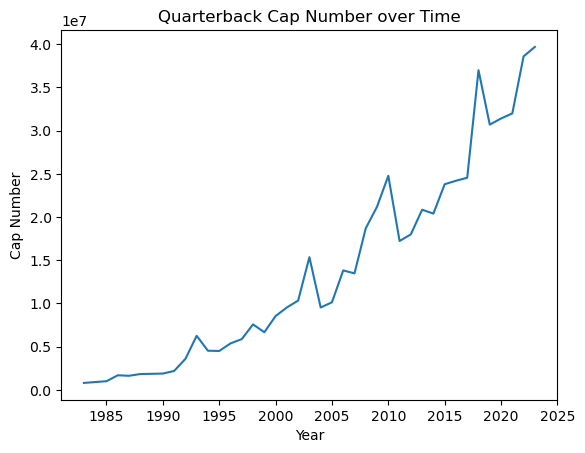

In [268]:
fig, ax = plt.subplots()
ax.plot(max_df['Year'], max_df['Cap Number'])
ax.set_xlabel('Year')
ax.set_ylabel('Cap Number')
ax.set_title('Quarterback Cap Number over Time')

## Deep Learning using Recurrent Neural Network (RNN)

In [371]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
import numpy as np

In [372]:
NUM_PREV_ITEMS = 3
np.random.seed(1)

In [373]:
# Normalize data
data = max_df.values[:, 1]
data = data.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
data = data.reshape(-1, 1)
data = scaler.fit_transform((data))

In [374]:
# Split into train and test split
train, test = data[0:int(len(data) * 0.7), :], data[int(len(data) * 0.7):len(data), :]

In [375]:
# Function that creates x and y for train and test
def reconstruct_data(dataset, n=1):
    x, y = [], []

    for j in range(len(dataset) - n - 1):
        a = dataset[j:(j+n), 0]
        x.append(a)
        y.append(dataset[j+n, 0])

    return np.array(x), np.array(y)

In [376]:
train_x, train_y = reconstruct_data(train, NUM_PREV_ITEMS)
test_x, test_y = reconstruct_data(test, NUM_PREV_ITEMS)

In [377]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [378]:
# Recurrent Neural Network model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(1, NUM_PREV_ITEMS)))
model.add(Dropout(0.5))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50))
model.add(Dropout(0.3))
model.add(Dense(units=1))

2023-08-14 16:22:38.893840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 16:22:38.894252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 16:22:38.894613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [379]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=2000, batch_size=4, verbose=2)

Epoch 1/2000


2023-08-14 16:22:40.561550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 16:22:40.562001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 16:22:40.562392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 - 1s - loss: 0.0479 - 1s/epoch - 228ms/step
Epoch 2/2000
6/6 - 0s - loss: 0.0425 - 11ms/epoch - 2ms/step
Epoch 3/2000
6/6 - 0s - loss: 0.0362 - 55ms/epoch - 9ms/step
Epoch 4/2000
6/6 - 0s - loss: 0.0297 - 29ms/epoch - 5ms/step
Epoch 5/2000
6/6 - 0s - loss: 0.0252 - 23ms/epoch - 4ms/step
Epoch 6/2000
6/6 - 0s - loss: 0.0209 - 20ms/epoch - 3ms/step
Epoch 7/2000
6/6 - 0s - loss: 0.0171 - 20ms/epoch - 3ms/step
Epoch 8/2000
6/6 - 0s - loss: 0.0184 - 22ms/epoch - 4ms/step
Epoch 9/2000
6/6 - 0s - loss: 0.0145 - 22ms/epoch - 4ms/step
Epoch 10/2000
6/6 - 0s - loss: 0.0137 - 23ms/epoch - 4ms/step
Epoch 11/2000
6/6 - 0s - loss: 0.0158 - 28ms/epoch - 5ms/step
Epoch 12/2000
6/6 - 0s - loss: 0.0113 - 11ms/epoch - 2ms/step
Epoch 13/2000
6/6 - 0s - loss: 0.0125 - 11ms/epoch - 2ms/step
Epoch 14/2000
6/6 - 0s - loss: 0.0126 - 10ms/epoch - 2ms/step
Epoch 15/2000
6/6 - 0s - loss: 0.0114 - 10ms/epoch - 2ms/step
Epoch 16/2000
6/6 - 0s - loss: 0.0102 - 11ms/epoch - 2ms/step
Epoch 17/2000
6/6 - 0s - loss:

In [380]:
# Get predictions
test_predict = model.predict(test_x)
test_predict = scaler.inverse_transform(test_predict)
test_labels = scaler.inverse_transform([test_y])

2023-08-14 16:23:08.237825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-14 16:23:08.239307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-14 16:23:08.240309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 376ms/step


In [381]:
test_score = mean_squared_error(test_labels[0], test_predict[:, 0])
print('Score on test set: %.2f MSE' % test_score)

Score on test set: 16124334006419.18 MSE


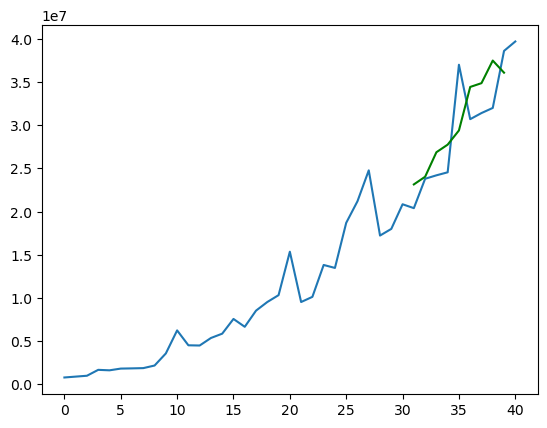

In [382]:
# Plot predictions
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_x) + 2 * NUM_PREV_ITEMS+1: len(data)-1, :] = test_predict
plt.plot(scaler.inverse_transform(data))
plt.plot(test_predict_plot, color='green')
plt.show()